In [1]:
import numpy as np
import matplotlib.pylab as plt

In [5]:
def rotation_matrix(omega, psi, phi):
    '''Rotation matrix defined with Euler's angles
        i.e. Body Rotation (intrisic) with axis order 'yxz'
    '''
    s_omega, c_omega = np.sin(omega), np.cos(omega)
    s_psi, c_psi = np.sin(psi), np.cos(psi)
    s_phi, c_phi = np.sin(phi), np.cos(phi)

    R = np.array([[ s_omega*s_phi*s_psi + c_omega*c_phi,
                    s_phi*c_psi,
                   -s_omega*c_phi + s_phi*s_psi*c_omega],
                  [ s_omega*s_psi*c_phi - s_phi*c_omega,
                    c_phi*c_psi,
                    s_omega*s_phi + s_psi*c_omega*c_phi],
                  [ s_omega*c_psi,
                   -s_psi,
                    c_omega*c_psi]])
    
    return R

In [12]:
R = rotation_matrix(3, 2, 1)
np.matmul(R, R.T)

array([[1.00000000e+00, 5.55111512e-17, 0.00000000e+00],
       [5.55111512e-17, 1.00000000e+00, 5.55111512e-17],
       [0.00000000e+00, 5.55111512e-17, 1.00000000e+00]])

In [27]:
def change_base(A, u, angles, offset):
    omega, psi, phi = angles
    offset = np.asarray(offset)

    R = rotation_matrix(omega, psi, phi)

    A_prime = np.matmul(A, R.T) - offset
    u_prime = np.matmul(u, R.T)
    
    return A_prime, u_prime

# test
u = np.array([[-1, 0, 0], [1, 1, 1]])
A = np.array([[1, 0, 0], [1, 0, 0]])

change_base(A, u, (np.pi/2, 0, 0), (0, 0, -1))

(array([[6.123234e-17, 0.000000e+00, 2.000000e+00],
        [6.123234e-17, 0.000000e+00, 2.000000e+00]]),
 array([[-6.123234e-17,  0.000000e+00, -1.000000e+00],
        [-1.000000e+00,  1.000000e+00,  1.000000e+00]]))

In [237]:
def rectangle_intersection(A, u, angles, offset, width, height):
    '''Projection of the ray (A, u) on the plane xy
        of the rotated (angles) and translated (offset) base
    '''
    A_prime, u_prime = change_base(A, u, angles, offset)

    time_to_plane = -np.divide(A_prime[:, 2], u_prime[:, 2],
                               where=u_prime[:, 2] < 0)

    B = A + time_to_plane[:, np.newaxis]*u  # point of intersection in the laboratory frame

    in_plane_uv = A_prime[:, 0:2] + time_to_plane[:, np.newaxis]*u_prime[:, 0:2]


    lost = time_to_plane < 0
    lost = np.logical_or(lost, np.abs(in_plane_uv[:, 0]) > width/2 )
    lost = np.logical_or(lost, np.abs(in_plane_uv[:, 1]) > height/2 )

    #in_plane_uv[mask, :] = np.NaN
    
    return lost, in_plane_uv, B

In [242]:
def plot_rectangle(uv, lost, rectangle_size, title='rectangle'):
    plt.plot(uv[~lost, 0], uv[~lost, 1], ',b') # inside
    plt.plot(uv[lost, 0], uv[lost, 1], ',r') # lost
    width, height = rectangle_size
    plt.plot([-width/2, width/2, width/2, -width/2, -width/2],
             [-height/2, -height/2, height/2, height/2, -height/2], '-',
             color='black', linewidth=1);
    #plt.axis('equal');
    plt.xlabel('u (mm)'); plt.ylabel('v (mm)')
    plt.title(title);

In [243]:
def normalize(array_of_vector):
    """ Normalize the given array of vectors.

        Parameters
        ----------
        array_of_vector : (N, dim) array
            vector along the last dim

        Returns
        -------
        y : array (N, dim)
    """
    array_of_vector = np.asarray(array_of_vector)
    norm = np.linalg.norm(array_of_vector, axis=-1, keepdims=True)

    return np.divide(array_of_vector, norm, where=norm > 0)

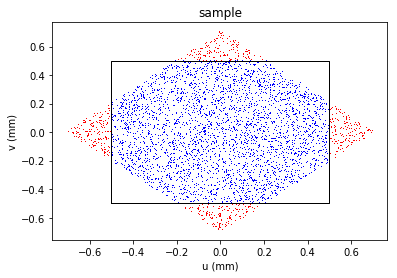

In [244]:
# test 1 - zero offset
N = 4000
u = np.zeros((N, 3)) - np.array((1, 0, 0))
A = (np.random.rand(N, 3)-.5) + np.array((10, 0, 0))

angles = (np.pi/2, 0, np.pi/4)
offset = (0, 0, 0)
width, height = 1, 1

lost, in_plane_uv, B = rectangle_intersection(A, u, angles, offset, width, height)

plot_rectangle(in_plane_uv, lost, (width, height), title='sample')

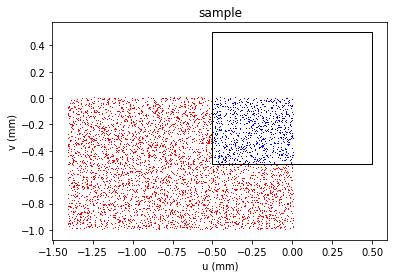

In [246]:
# test 2 - offset
N = 5000
u = np.zeros((N, 3)) - np.array((1, 0, 0))
A = (np.random.rand(N, 3)-.5) + np.array((10, 0, 0))

angles = (np.pi/4, 0, 0)
offset = (-.3, .5, -1)
width, height = 1, 1

lost, in_plane_uv, B = rectangle_intersection(A, u, angles, offset, width, height)

plot_rectangle(in_plane_uv, lost, (width, height), title='sample')

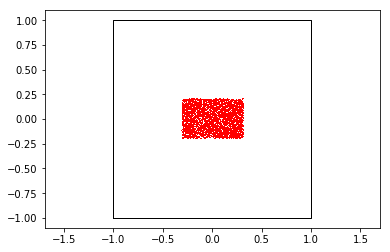

In [248]:
# test diffract - old
theta = 140 *np.pi/180
deuxtheta = 2*theta

N = 5100
u = np.zeros((N, 3)) - np.array((1, 0, 0))
A = 0.4*(np.random.rand(N, 3)-0.5) + np.array((10, 0, 0))

gamma = np.pi/2 * (np.random.rand(N,) - 0.5)

# sample
angles = (theta, 0, 0)
offset = (0, 0, 0)
width, height = 2, 2

mask, in_plane_uv, B = rectangle_intersection(A, u, angles, offset, width, height)

# graph
plt.plot(in_plane_uv[~mask, 0], in_plane_uv[~mask, 1], ',r')
plt.plot(in_plane_uv[mask, 0], in_plane_uv[mask, 1], ',b')
plt.plot([-width/2, width/2, width/2, -width/2, -width/2],
         [-height/2, -height/2, height/2, height/2, -height/2], '-', color='black', linewidth=1)
plt.axis('equal');

In [249]:
# Diffracted directions

def planar_powder(A, u,
                  angles, offset, sample_size,
                  gamma, deuxtheta):
    '''Diffraction by a powder'''
    mask, uv, B = rectangle_intersection(A, u,
                                         angles, offset, *sample_size)


    ref_plane_normal = np.array((.0, 1., .0))

    u = normalize(u)
    ref_plane_normal = normalize(ref_plane_normal)

    # Define a new base with u
    gamma_zero = normalize(np.cross(ref_plane_normal, u))
    gamma_90 = normalize(np.cross(u, gamma_zero))

    # diffracted direction:
    d = u + np.tan(deuxtheta)*(gamma_zero*np.cos(gamma)[:, np.newaxis] + \
                               gamma_90*np.sin(gamma)[:, np.newaxis])
    
    return B, d, mask, uv

# diffract

    # Parameters
     - Incident beam, source & optique
         A: beam size --> distribution
         u: divergence --> distribution
         lambda: energy --> distribution
     - Sample
         size: height, width
         d(hkl) --> distribution / discrete
         (absorption, grain size, monocristal...)
     - Diffraction
         gamma (relative to lab. XZ plane) --> distribution
     - Detecteur
         geometry: slit width and height, offset

    # Gonio movements, scan, measure:
     - sample stage: omega, phi, psi, X, Y, Z
     - detecteur position: 2theta

In [270]:
# Gonio
omega, psi, phi = 36, 0, 0 # deg, sample stage orientation
X, Y, Z = 0, 0, 0 # mm, sample stage position

deuxtheta = 30 *np.pi/180  # rad, detector position

gonio_radius = 320 # mm


# sample
sample_size = 15, 15  # mm, width, height
deuxtheta_diff = 30 *np.pi/180  # rad, diffraction angle (d_hkl)

# incident beam
N = 5100

# Source
u = np.zeros((N, 3)) - np.array((1, 0, 0)) # divergencce

Ax = np.ones((N, 1)) * gonio_radius
A_width = (np.random.randn(N, 1)) * 12  # Gaussian
A_height = (np.random.rand(N, 1) - 0.5) * .2  # mm, Square
A = np.hstack([Ax, A_width, A_height])
    
gamma = np.pi/9 * (np.random.rand(N,) - 0.5)

# Diffraction
angles = np.pi/180*np.array([omega, psi, phi])
B, d, lost_at_sample, uv_sample = planar_powder(A, u,
                     angles, (X, Y, Z), sample_size,
                     gamma, deuxtheta_diff)

# Detector
width, height = gonio_radius*1/4. *np.pi/180, 20 # mm

angles = (deuxtheta + np.pi/2, 0, 0) # i.e. omega, phi, psi
offset = (0, 0, -gonio_radius)

lost_detect, uv_detector, C = rectangle_intersection(B, d,
                                                     angles, offset,
                                                     width, height)

lost = lost_detect + lost_at_sample

# sum
I = np.sum(~lost)
print(I)

861


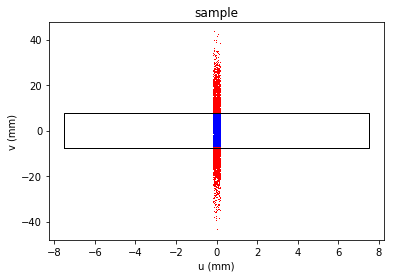

In [271]:
plot_rectangle(uv_sample, lost_at_sample, sample_size, title='sample')

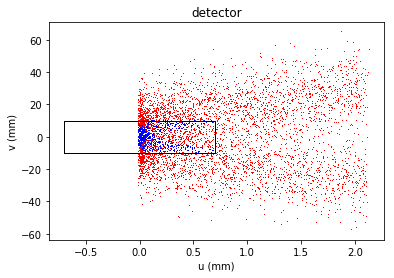

In [272]:
plot_rectangle(uv_detector, lost, (width, height), title='detector')

In [299]:
def scan_2theta_omega(deuxtheta_deg):
    # Gonio
    omega, psi, phi = deuxtheta_deg/2, 0, 0 # deg, sample stage orientation
    X, Y, Z = 0, 0, 0 # mm, sample stage position

    deuxtheta = deuxtheta_deg *np.pi/180  # rad, detector position

    gonio_radius = 320 # mm

    # sample
    sample_size = 12, 10  # mm, width, height
    deuxtheta_diff = 55 *np.pi/180  # rad, diffraction angle (d_hkl)

    # incident beam
    N = 55100

    # Source
    u = np.zeros((N, 3)) - np.array((1, 0, 0)) # divergencce

    Ax = np.ones((N, 1)) * gonio_radius
    A_width = (np.random.randn(N, 1)) * 12  # Gaussian
    A_height = (np.random.rand(N, 1) - 0.5) * .2  # mm, Square
    A = np.hstack([Ax, A_width, A_height])

    gamma = np.pi/9 * (np.random.rand(N,) - 0.5)

    # Diffraction
    angles = np.pi/180*np.array([omega, psi, phi])
    B, d, lost_at_sample, uv_sample = planar_powder(A, u,
                         angles, (X, Y, Z), sample_size,
                         gamma, deuxtheta_diff)

    # Detector
    width, height = gonio_radius*1/4. *np.pi/180, 20 # mm

    angles = (deuxtheta + np.pi/2, 0, 0) # i.e. omega, phi, psi
    offset = (0, 0, -gonio_radius)

    lost_detect, uv_detector, C = rectangle_intersection(B, d,
                                                         angles, offset,
                                                         width, height)

    lost = lost_detect + lost_at_sample

    # sum
    I = np.sum(~lost)
    return I

In [300]:
dt_range = 1
deuxtheta = 55
deuxtheta_span = np.linspace(-dt_range/2+deuxtheta,
                             +dt_range/2+deuxtheta, 76)
I = [scan_2theta_omega(dt) for dt in deuxtheta_span]

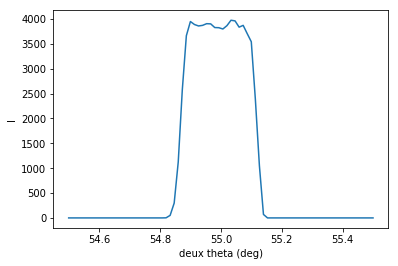

In [301]:
plt.plot(deuxtheta_span, I);
plt.xlabel('deux theta (deg)');
plt.ylabel('I');